In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
# from sklearn import datasets


6


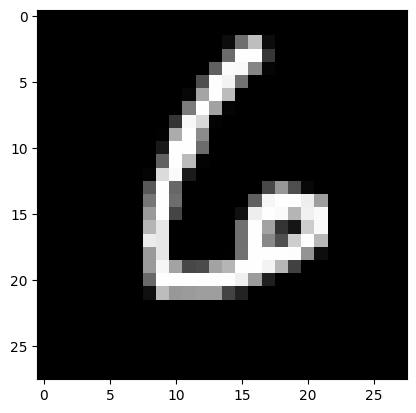

In [ ]:
from torchvision.datasets import MNIST

common_transform = transforms.Compose([
    transforms.ToTensor(),                 # -> [0,1], [C,H,W]
    transforms.Normalize((0.5,), (0.5,))   # all datasets normalized the same
])


mnist_train = MNIST(root="./data", train=True,  download=True, transform=common_transform)
mnist_test  = MNIST(root="./data", train=False, download=True, transform=common_transform)

mnist_train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
mnist_test_loader  = DataLoader(mnist_test, batch_size=64, shuffle=False)

img_idx = 50002
img_0 = mnist_train.data[img_idx]
img_0_label = mnist_train.targets[img_idx].item()
print(img_0_label)
plt.imshow(img_0, cmap='gray')
plt.show()


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mloey1/ahdd1")

print("Path to dataset files:", path)

!cp -r {path}/* .
!ls

Using Colab cache for faster access to the 'ahdd1' dataset.
Path to dataset files: /kaggle/input/ahdd1
'Arabic Handwritten Digits Dataset CSV'  'csvTrainLabel 60k x 1.csv'
'csvTestImages 10k x 784.csv'		  data
'csvTestLabel 10k x 1.csv'		  sample_data
'csvTrainImages 60k x 784'		 'Train + Test Matlab.mat'
'csvTrainImages 60k x 784.csv'


In [ ]:
# Paths
train_img_path = "csvTrainImages 60k x 784.csv"
train_lbl_path = "csvTrainLabel 60k x 1.csv"
test_img_path  = "csvTestImages 10k x 784.csv"
test_lbl_path  = "csvTestLabel 10k x 1.csv"

train_images = pd.read_csv(train_img_path, header=None).values.astype(np.uint8)
train_labels = pd.read_csv(train_lbl_path, header=None).values.astype(np.int64).flatten()

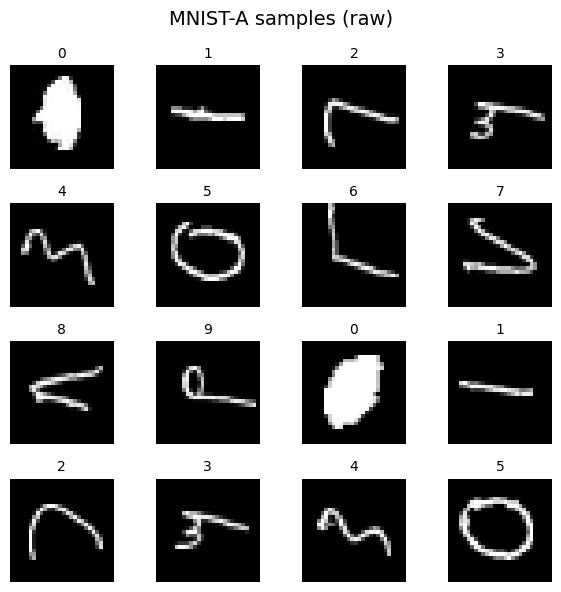

In [ ]:

# Parameters you can tweak live
start_idx = 50000
num_images = 16      # must be a square number: 4, 9, 16, 25, ...
grid_size = int(np.sqrt(num_images))

fig, axes = plt.subplots(grid_size, grid_size, figsize=(6, 6))

for i, ax in enumerate(axes.flat):
    idx = start_idx + i
    img = train_images[idx].reshape(28, 28)
    label = train_labels[idx]

    ax.imshow(img, cmap="gray")
    ax.set_title(f"{label}", fontsize=10)
    ax.axis("off")

plt.suptitle("MNIST-A samples (raw)", fontsize=14)
plt.tight_layout()
plt.show()


# Class exercise — Data correctness and responsibility

* What is wrong with these images?
* What needs to change so that the digits **match their labels** and can be used for training?
* **Apply the fix at the Dataset / DataLoader level**, not only for a single image. Your solution should apply consistently to all samples returned by the DataLoader.

* Verify your solution by displaying at least 8–16 images from the DataLoader.

*Important*:

The goal is not to “fix this picture”.
The goal is to ensure that **every image returned by the DataLoader is correct**, everywhere it is used.


**Why this matters (read carefully)**
* Fixing a single image is a demo.
* Fixing the Dataset is engineering.
* Models will happily train on incorrect data — they will not warn you.

In [ ]:
from torch import nn


class CNNM(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),  # (B,16,28,28)
            nn.ReLU(),
            nn.MaxPool2d(2),                 # (B,16,14,14)

            nn.Conv2d(16, 32, 3, padding=1), # (B,32,14,14)
            nn.ReLU(),
            nn.MaxPool2d(2),                 # (B,32,7,7)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


## Class Exercise — Part 2: “When a working model suddenly doesn’t”

### Goal
Train a small CNN (CNNM) on **MNIST** only.  
Then evaluate it on **MNIST-A** **without any retraining**.

### What you should observe
- MNIST accuracy becomes high quickly.
- MNIST-A accuracy drops a lot (domain shift).
- Some digits fail more than others.
- The model can be confidently wrong.

### Rules
- Do **not** retrain on MNIST-A yet.
- Only swap the dataloader for evaluation.


In [3]:
device = torch.device(
    # NVIDIA CUDA GPU support, this should include support for AMD via ROCm (experimental)
    "cuda"
    if torch.cuda.is_available()
    # Apple M-series GPU support
    else "mps"
    if torch.backends.mps.is_available()
    # Default to CPU
    else "cpu"
)
print("device:", device)

device: mps


## Training & evaluation utilities (provided)
You should already “know this”, so we’re giving you clean helpers to save time.


In [ ]:
@torch.no_grad()
def evaluate(model, loader, max_batches=None):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    for b, (x, y) in enumerate(loader):
        if max_batches is not None and b >= max_batches:
            break

        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        logits = model(x)
        loss = criterion(logits, y)

        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.numel()
        total_loss += loss.item() * y.size(0)

    avg_loss = total_loss / max(total, 1)
    acc = correct / max(total, 1)
    return avg_loss, acc


def train_one_epoch(model, loader, optimizer):
    model.train()
    criterion = nn.CrossEntropyLoss()

    running_loss = 0.0
    correct = 0
    total = 0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * y.size(0)
        correct += (logits.argmax(dim=1) == y).sum().item()
        total += y.numel()

    return running_loss / max(total, 1), correct / max(total, 1)


## Step 1 — Train CNNM on MNIST (short run)

We’ll train for a few epochs just to get a “working MNIST model”.


In [ ]:
model = CNNM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

history = []
EPOCHS = 4  # keep short for class

t0 = time.time()
for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(model, mnist_train_loader, optimizer)
    te_loss, te_acc = evaluate(model, mnist_test_loader)

    history.append((epoch, tr_loss, tr_acc, te_loss, te_acc))
    print(f"epoch {epoch:02d} | train loss={tr_loss:.4f} acc={tr_acc:.3f} | test loss={te_loss:.4f} acc={te_acc:.3f}")

print(f"\nTraining time: {time.time() - t0:.1f}s")


epoch 01 | train loss=0.2711 acc=0.918 | test loss=0.0636 acc=0.979
epoch 02 | train loss=0.0859 acc=0.974 | test loss=0.0447 acc=0.985
epoch 03 | train loss=0.0669 acc=0.980 | test loss=0.0378 acc=0.987
epoch 04 | train loss=0.0559 acc=0.983 | test loss=0.0360 acc=0.987

Training time: 175.9s


## Step 2 — The actual exercise: evaluate on MNIST-A **without retraining**

Do NOT change the model weights.  
Just evaluate the trained MNIST model on MNIST-A and compare.

**Important:**  
Poor performance on MNIST-A at this stage is expected and not a failure.


## Step 3 — Where does it fail? (per-class accuracy)

This helps you see which digits suffer most under domain shift.


## Class Exercise — Confusion Matrix (MNIST vs MNIST-A)

So far we compared **overall accuracy**.  
Now we want to understand **how** the model fails.

### Task
Compute and visualize a **confusion matrix** for:
- MNIST (model trained on MNIST, tested on MNIST)
- MNIST-A (same model, tested on MNIST-A)

### Reminder: what is a confusion matrix?
For a classification problem with 10 classes:
- Rows = **true labels**
- Columns = **predicted labels**
- Entry (i, j) = how many samples of class *i* were predicted as *j*

Perfect classifier → matrix is diagonal.

---

### Step 1 — Collect predictions and true labels

You need:
- all true labels from the test set
- all predicted labels from the model

Hints:
- use `model.eval()` and `torch.no_grad()`
- loop over the test DataLoader
- use `argmax(dim=1)` on model outputs
- move tensors to CPU before converting to NumPy

You should end up with two 1D arrays:
- `y_true`
- `y_pred`


### Step 2 — Compute the confusion matrix

Reminder options:
- `sklearn.metrics.confusion_matrix(y_true, y_pred)`
- OR build it manually using NumPy (counts in a 10×10 array)

Either approach is fine.

Make sure:
- shape is (10, 10)
- labels 0–9 are in the correct order


## (Hint) Confusion matrix helper — skeleton only

You may use this function signature **or write your own**.

Goal:
- iterate over a DataLoader
- collect true labels and predicted labels
- return a confusion matrix of shape (10, 10)

You decide how to implement the internals.


In [ ]:
def compute_confusion_matrix(model, loader, num_classes=10):
    """
    Args:
        model: trained PyTorch model
        loader: DataLoader (MNIST or MNIST-A test set)
        num_classes: number of classes (default: 10)

    Returns:
        cm: NumPy array of shape (num_classes, num_classes)
            rows = true labels
            cols = predicted labels
    """
    # TODO:
    # - set model to eval mode
    # - disable gradients
    # - iterate over loader
    # - get predictions with argmax
    # - accumulate counts into a (num_classes, num_classes) array
    raise NotImplementedError


### Step 3 — Visualize with matplotlib

Requirements:
- use `plt.imshow(...)`
- add a colorbar
- label axes:
  - x-axis: "Predicted label"
  - y-axis: "True label"
- add a title (MNIST or MNIST-A)

Optional (recommended):
- normalize rows so each row sums to 1
- annotate cells with values (especially useful)

Reminder:
- confusion matrices are *interpretable visual tools*, not just numbers


### Step 4 — Interpretation (answer in words)

Answer briefly:
1. Which digits are most often confused?
2. Is the confusion symmetric?
3. How does MNIST-A differ from MNIST?
4. Does this explain the drop in accuracy?

You do **not** need to fix the model yet.


### ⛔ Stop here in class

If you reached this point, you should have:
- MNIST and MNIST-A dataloaders working
- MNIST-A digits correctly oriented and mirrored
- CNNM trained on MNIST
- CNNM evaluated on MNIST-A **without retraining**

Next: Transfer Learning (homework).


## Discussion questions

1. Why did accuracy drop so much on MNIST-A?
2. Which digits suffered most? Any pattern?
3. The model is sometimes confidently wrong — why doesn’t the model “know” it’s out of distribution?

### Next step (homework / next class)
Now we will fix this using **Transfer Learning**:
- Continue training on MNIST-A (no freezing)
- Freeze all layers except the last FC layers, retrain on MNIST-A
- Compare speed and final performance, and test back on MNIST
